In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import warnings
warnings.filterwarnings("ignore")

In [2]:
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c',
    password='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password',
    database='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db'
)

In [204]:
query1=''' 
    select o.id as order_id,
    o.created_at::date as order_date,
    o.email as user_id,
    o.total_line_items_price as MRP,
    o.total_discounts as discount_amount,
    total_price as total_price
    
    from orders o
    WHERE
    cancelled_at is NULL;
'''

In [205]:
query2=''' 
    select oli.order_id as order_id,
    oli.product_id as product_id,
    oli.name as product_name,
    oli.quantity as quantity,
    oli.price as sp
    from order_line_item oli;
'''

In [206]:
o=pd.read_sql(query1,conn)

In [207]:
r=pd.read_sql(query2,conn)

In [208]:
data=pd.merge(o,r,on='order_id',how='left')
data['order_id'].nunique()

72873

In [209]:
data['user_id'].nunique()

44486

In [210]:
o#.isnull().sum()

,order_id,order_date,user_id,mrp,discount_amount,total_price
0,5341764845706,2023-12-08,agmathew1@gmail.com,299.0,0.0,299.0
1,5341763338378,2023-12-08,sdfashion19@gmail.com,199.0,0.0,224.0
2,5341750689930,2023-12-08,shrighadge1965@gmail.com,598.0,0.0,598.0
3,5341738500234,2023-12-08,rajan.raju58@gmail.com,299.0,0.0,324.0
4,5341737910410,2023-12-08,shantha7788@gmail.com,299.0,0.0,324.0
...,...,...,...,...,...,...
72868,5294855258250,2023-11-22,nayanthadlani609@gmail.com,639.0,176.0,488.0
72869,5294417412234,2023-11-22,sirajansari9312@gmail.com,199.0,0.0,224.0
72870,5288648540298,2023-11-21,lutfalhoque72@gmail.com,199.0,0.0,224.0
72871,5288405631114,2023-11-21,bchhetri04121984@gmail.com,299.0,0.0,324.0


In [211]:
data#['order_id'].nunique()#.info()

,order_id,order_date,user_id,mrp,discount_amount,total_price,product_id,product_name,quantity,sp
0,5341764845706,2023-12-08,agmathew1@gmail.com,299.0,0.0,299.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,299.0
1,5341763338378,2023-12-08,sdfashion19@gmail.com,199.0,0.0,224.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,199.0
2,5341750689930,2023-12-08,shrighadge1965@gmail.com,598.0,0.0,598.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,2,299.0
3,5341738500234,2023-12-08,rajan.raju58@gmail.com,299.0,0.0,324.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,299.0
4,5341737910410,2023-12-08,shantha7788@gmail.com,299.0,0.0,324.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,299.0
...,...,...,...,...,...,...,...,...,...,...
95216,5294855258250,2023-11-22,nayanthadlani609@gmail.com,639.0,176.0,488.0,5.321621e+12,South Indian Traditional Filter Coffee - Mediu...,1,440.0
95217,5294417412234,2023-11-22,sirajansari9312@gmail.com,199.0,0.0,224.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,199.0
95218,5288648540298,2023-11-21,lutfalhoque72@gmail.com,199.0,0.0,224.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,199.0
95219,5288405631114,2023-11-21,bchhetri04121984@gmail.com,299.0,0.0,324.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,299.0


In [212]:
data[data['order_id']==3985063379082]

,order_id,order_date,user_id,mrp,discount_amount,total_price,product_id,product_name,quantity,sp
71487,3985063379082,2022-03-23,urmila.vishwas@gmail.com,8896.0,2668.8,6227.2,5.320325e+12,Mysore Nuggets - Speciality Blend - Pour Over ...,1,520.0
71488,3985063379082,2022-03-23,urmila.vishwas@gmail.com,8896.0,2668.8,6227.2,5.320325e+12,Mysore Nuggets - Speciality Blend - French Pre...,1,520.0
71489,3985063379082,2022-03-23,urmila.vishwas@gmail.com,8896.0,2668.8,6227.2,5.320286e+12,Baba Budangiri Estate Coffee - Pour Over / 250 gm,1,510.0
71490,3985063379082,2022-03-23,urmila.vishwas@gmail.com,8896.0,2668.8,6227.2,5.320286e+12,Baba Budangiri Estate Coffee - French Press / ...,1,510.0
71491,3985063379082,2022-03-23,urmila.vishwas@gmail.com,8896.0,2668.8,6227.2,5.321724e+12,Blonde Caramel - Speciality Blend - Pour Over ...,1,600.0
71492,3985063379082,2022-03-23,urmila.vishwas@gmail.com,8896.0,2668.8,6227.2,5.321724e+12,Blonde Caramel - Speciality Blend - French Pre...,1,600.0
71493,3985063379082,2022-03-23,urmila.vishwas@gmail.com,8896.0,2668.8,6227.2,5.320258e+12,Thippanahalli Estate Coffee - Pour Over / 250 gm,1,468.0
71494,3985063379082,2022-03-23,urmila.vishwas@gmail.com,8896.0,2668.8,6227.2,5.320258e+12,Thippanahalli Estate Coffee - French Press / 2...,1,468.0
71495,3985063379082,2022-03-23,urmila.vishwas@gmail.com,8896.0,2668.8,6227.2,6.584809e+12,Mullayangiri Estate Coffee - 250 gm / Pour Over,1,550.0
71496,3985063379082,2022-03-23,urmila.vishwas@gmail.com,8896.0,2668.8,6227.2,6.584809e+12,Mullayangiri Estate Coffee - 250 gm / French P...,1,550.0


In [213]:
data['order_id'].nunique()

72873

In [214]:
data['order_date']=pd.to_datetime(data['order_date'])

In [215]:
#New/Repeat Tag
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel



data = data[data['order_date'] >= '2023-01-01']
data=data[data['order_date'] <= '2023/12/31']

data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1


#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()


In [216]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49900 entries, 0 to 49899
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   order_id         49900 non-null  int64         
 1   order_date       49900 non-null  datetime64[ns]
 2   user_id          49900 non-null  object        
 3   mrp              49900 non-null  float64       
 4   discount_amount  49900 non-null  float64       
 5   total_price      49900 non-null  float64       
 6   product_id       49900 non-null  float64       
 7   product_name     49900 non-null  object        
 8   quantity         49900 non-null  int64         
 9   sp               49900 non-null  float64       
 10  TrxnRank         49900 non-null  float64       
 11  New              49900 non-null  int64         
 12  Repeat           49900 non-null  int64         
 13  ordervalue       49900 non-null  float64       
 14  AOVContribution  49900 non-null  float

In [217]:
data['discount_ratio'] = data['discount_amount']/data['mrp']
data

,order_id,order_date,user_id,mrp,discount_amount,total_price,product_id,product_name,quantity,sp,TrxnRank,New,Repeat,ordervalue,AOVContribution,discount_ratio
0,5341764845706,2023-12-08,agmathew1@gmail.com,299.0,0.0,299.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,299.0,2.0,0,1,299.0,0.007855,0.00000
1,5341763338378,2023-12-08,sdfashion19@gmail.com,199.0,0.0,224.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,199.0,1.0,1,0,199.0,0.005228,0.00000
2,5341750689930,2023-12-08,shrighadge1965@gmail.com,598.0,0.0,598.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,2,299.0,3.0,0,1,598.0,0.015710,0.00000
3,5341738500234,2023-12-08,rajan.raju58@gmail.com,299.0,0.0,324.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,299.0,1.0,1,0,299.0,0.007855,0.00000
4,5341737910410,2023-12-08,shantha7788@gmail.com,299.0,0.0,324.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,299.0,6.0,0,1,299.0,0.007855,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49895,5294855258250,2023-11-22,nayanthadlani609@gmail.com,639.0,176.0,488.0,5.321621e+12,South Indian Traditional Filter Coffee - Mediu...,1,440.0,1.0,1,0,440.0,0.011559,0.27543
49896,5294417412234,2023-11-22,sirajansari9312@gmail.com,199.0,0.0,224.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,199.0,1.0,1,0,199.0,0.005228,0.00000
49897,5288648540298,2023-11-21,lutfalhoque72@gmail.com,199.0,0.0,224.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,199.0,1.0,1,0,199.0,0.005228,0.00000
49898,5288405631114,2023-11-21,bchhetri04121984@gmail.com,299.0,0.0,324.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,299.0,1.0,1,0,299.0,0.007855,0.00000


In [218]:
data['new_ordervalue']= data['ordervalue']-(data['ordervalue']*data['discount_ratio'])

In [244]:
totalcarts=data['order_id'].nunique()
product_level=data.groupby(['product_name']).agg(
        Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
        Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
        ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
        NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
        RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
        Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
        Total_Order_Value=pd.NamedAgg(column='new_ordervalue', aggfunc='sum'),
        Order_Count=pd.NamedAgg(column='order_id', aggfunc='nunique')
).reset_index()

# produser=data.groupby(['product_name','user_id']).agg(
#     New_user=pd.NamedAgg(column='user_id', aggfunc='nunique')
# ).reset_index()

# produser_newcount=produser.groupby('product_name').agg(
#     New_count=pd.NamedAgg(column='New_user', aggfunc='sum')
# ).reset_index()

# data_repeat=data[data['TrxnRank']==2]
# produser_repeatcount=data_repeat.groupby('user_id').agg(
#     Repeat_count=pd.NamedAgg(column='user_id', aggfunc='nunique')
# ).reset_index()

# k=pd.merge(produser,produser_repeatcount,on='user_id',how='left')
# k.fillna(0)
# k1=k.groupby('product_name').agg(
#     Repeat_count=pd.NamedAgg(column='Repeat_count', aggfunc='sum')
# ).reset_index()


In [245]:
data[data['order_id']==5374839521418]

,order_id,order_date,user_id,mrp,discount_amount,total_price,product_id,product_name,quantity,sp,TrxnRank,New,Repeat,ordervalue,AOVContribution,discount_ratio,new_ordervalue
49399,5374839521418,2023-12-31,kgranpise53@gmail.com,199.0,0.0,224.0,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,199.0,1.0,1,0,199.0,0.005228,0.0,199.0


In [246]:
data_new=data[data['TrxnRank']==1]

In [247]:
xuser_count = data_new.groupby(["product_name"]).agg(
    x_trxn_pool = pd.NamedAgg(column = "user_id", aggfunc = 'nunique'),
    x_user_list = pd.NamedAgg(column = "user_id", aggfunc = lambda x: [x.unique()])
).reset_index()



data_repeat=data[data['TrxnRank']==2]

repeat_users=data_repeat['user_id'].to_list()

l=[]
for i in range (len(xuser_count)):
    a=(xuser_count.iloc[i,2])[0]
    b=[x for x in a if x in repeat_users]
    l.append(len(b))

xuser_count['repeat_pool']=l

yuser_count = data_repeat.groupby('product_name').agg(
    y_trxn_pool = pd.NamedAgg(column = "user_id", aggfunc = 'nunique')
).reset_index()
    
main_grouped_for_title = pd.merge(xuser_count, yuser_count, on='product_name', how='left')
main_grouped_for_title['y_trxn_pool'].fillna(0, inplace=True)

result = main_grouped_for_title.copy()

result['Conversion_Rate_x_to_y'] = result['repeat_pool']/result['x_trxn_pool']
result['Conversion_Rate_x_to_y'].fillna(0, inplace= True) 

In [248]:
result

,product_name,x_trxn_pool,x_user_list,repeat_pool,y_trxn_pool,Conversion_Rate_x_to_y
0,Aerolatte Steam Free Milk Frother With Stand -...,11,"[[dyslexicprophet@gmail.com, kritikaseth45@gma...",1,2.0,0.090909
1,Aerolatte Steam Free Milk Frother With Stand -...,1,[[bhavnabhardwaj@yahoo.com]],0,1.0,0.000000
2,Aeropress Coffee Maker,8,"[[jinitsoni3@gmail.com, neetisingh0808@gmail.c...",1,1.0,0.125000
3,Aeropress Filter Paper,2,"[[emailrampi@gmail.com, akshit4321@gmail.com]]",1,0.0,0.500000
4,Aeropress Go Coffee Maker,1,[[abhishek.sheth14@gmail.com]],0,1.0,0.000000
...,...,...,...,...,...,...
508,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,190,"[[malemlongjam16jk@gmail.com, nosaefe00@gmail....",21,40.0,0.110526
509,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,72,"[[shankarsiddhartha@yahoo.com, laishramrobindr...",11,44.0,0.152778
510,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,5,"[[shikhirv@gmail.com, khushipeshattiwar@gmail....",1,3.0,0.200000
511,Whiskey Barrel Aged Hot Brew Sachets & Enamel ...,11,"[[vageesha89@gmail.com, geetakushagra5@gmail.c...",0,2.0,0.000000


In [249]:
xuser_count['repeat_pool'].sum()/xuser_count['x_trxn_pool'].sum()

0.17219042827495126

In [250]:
# result.drop(columns=['x_trxn_pool','y_trxn_pool'], inplace=True)
conversion_result = result

In [251]:
conversion_result

,product_name,x_trxn_pool,x_user_list,repeat_pool,y_trxn_pool,Conversion_Rate_x_to_y
0,Aerolatte Steam Free Milk Frother With Stand -...,11,"[[dyslexicprophet@gmail.com, kritikaseth45@gma...",1,2.0,0.090909
1,Aerolatte Steam Free Milk Frother With Stand -...,1,[[bhavnabhardwaj@yahoo.com]],0,1.0,0.000000
2,Aeropress Coffee Maker,8,"[[jinitsoni3@gmail.com, neetisingh0808@gmail.c...",1,1.0,0.125000
3,Aeropress Filter Paper,2,"[[emailrampi@gmail.com, akshit4321@gmail.com]]",1,0.0,0.500000
4,Aeropress Go Coffee Maker,1,[[abhishek.sheth14@gmail.com]],0,1.0,0.000000
...,...,...,...,...,...,...
508,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,190,"[[malemlongjam16jk@gmail.com, nosaefe00@gmail....",21,40.0,0.110526
509,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,72,"[[shankarsiddhartha@yahoo.com, laishramrobindr...",11,44.0,0.152778
510,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,5,"[[shikhirv@gmail.com, khushipeshattiwar@gmail....",1,3.0,0.200000
511,Whiskey Barrel Aged Hot Brew Sachets & Enamel ...,11,"[[vageesha89@gmail.com, geetakushagra5@gmail.c...",0,2.0,0.000000


In [252]:
productlevel=pd.merge(product_level,conversion_result,on='product_name', how='left')

In [253]:
productlevel

,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,Total_Order_Value,Order_Count,x_trxn_pool,x_user_list,repeat_pool,y_trxn_pool,Conversion_Rate_x_to_y
0,Aerolatte Steam Free Milk Frother With Stand -...,14,14,1950.000000,11,3,14,0.717194,25137.626806,14,11.0,"[[dyslexicprophet@gmail.com, kritikaseth45@gma...",1.0,2.0,0.090909
1,Aerolatte Steam Free Milk Frother With Stand -...,2,2,2150.000000,1,1,2,0.112965,4300.000000,2,1.0,[[bhavnabhardwaj@yahoo.com]],0.0,1.0,0.000000
2,Aeropress Coffee Maker,11,11,3827.272727,8,3,11,1.106003,39633.544545,11,8.0,"[[jinitsoni3@gmail.com, neetisingh0808@gmail.c...",1.0,1.0,0.125000
3,Aeropress Filter Paper,2,2,520.000000,2,0,2,0.027322,1040.000000,2,2.0,"[[emailrampi@gmail.com, akshit4321@gmail.com]]",1.0,0.0,0.500000
4,Aeropress Go Coffee Maker,2,2,4450.000000,1,1,2,0.233811,8628.697404,2,1.0,[[abhishek.sheth14@gmail.com]],0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,251,263,490.000000,193,62,240,3.385525,65666.618768,251,190.0,"[[malemlongjam16jk@gmail.com, nosaefe00@gmail....",21.0,40.0,0.110526
603,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,177,214,650.000000,72,107,158,3.654276,74121.910659,177,72.0,"[[shankarsiddhartha@yahoo.com, laishramrobindr...",11.0,44.0,0.152778
604,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,11,14,1300.000000,5,6,11,0.478130,9644.270732,11,5.0,"[[shikhirv@gmail.com, khushipeshattiwar@gmail....",1.0,3.0,0.200000
605,Whiskey Barrel Aged Hot Brew Sachets & Enamel ...,14,14,1550.000000,11,3,14,0.570077,19989.506173,14,11.0,"[[vageesha89@gmail.com, geetakushagra5@gmail.c...",0.0,2.0,0.000000


In [254]:
productlevel

,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,Total_Order_Value,Order_Count,x_trxn_pool,x_user_list,repeat_pool,y_trxn_pool,Conversion_Rate_x_to_y
0,Aerolatte Steam Free Milk Frother With Stand -...,14,14,1950.000000,11,3,14,0.717194,25137.626806,14,11.0,"[[dyslexicprophet@gmail.com, kritikaseth45@gma...",1.0,2.0,0.090909
1,Aerolatte Steam Free Milk Frother With Stand -...,2,2,2150.000000,1,1,2,0.112965,4300.000000,2,1.0,[[bhavnabhardwaj@yahoo.com]],0.0,1.0,0.000000
2,Aeropress Coffee Maker,11,11,3827.272727,8,3,11,1.106003,39633.544545,11,8.0,"[[jinitsoni3@gmail.com, neetisingh0808@gmail.c...",1.0,1.0,0.125000
3,Aeropress Filter Paper,2,2,520.000000,2,0,2,0.027322,1040.000000,2,2.0,"[[emailrampi@gmail.com, akshit4321@gmail.com]]",1.0,0.0,0.500000
4,Aeropress Go Coffee Maker,2,2,4450.000000,1,1,2,0.233811,8628.697404,2,1.0,[[abhishek.sheth14@gmail.com]],0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,251,263,490.000000,193,62,240,3.385525,65666.618768,251,190.0,"[[malemlongjam16jk@gmail.com, nosaefe00@gmail....",21.0,40.0,0.110526
603,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,177,214,650.000000,72,107,158,3.654276,74121.910659,177,72.0,"[[shankarsiddhartha@yahoo.com, laishramrobindr...",11.0,44.0,0.152778
604,Vanilla Cold Brew Bags | Free Mason Jar - Pack...,11,14,1300.000000,5,6,11,0.478130,9644.270732,11,5.0,"[[shikhirv@gmail.com, khushipeshattiwar@gmail....",1.0,3.0,0.200000
605,Whiskey Barrel Aged Hot Brew Sachets & Enamel ...,14,14,1550.000000,11,3,14,0.570077,19989.506173,14,11.0,"[[vageesha89@gmail.com, geetakushagra5@gmail.c...",0.0,2.0,0.000000


In [255]:
# productlevel=pd.merge(product_level,produser_newcount, on='product_name', how='left')
# productlevel=pd.merge(productlevel,k1,on='product_name',how='left')

productlevel['NewRepeatConversionRatio']=productlevel['Conversion_Rate_x_to_y']
productlevel['NewRepeatConversionRatio'].fillna(0)
productlevel=productlevel.sort_values('NewRepeatConversionRatio')
productlevel['CartPenetration']=productlevel['Carts']/totalcarts
productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

In [256]:
productlevel

,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,Total_Order_Value,Order_Count,x_trxn_pool,x_user_list,repeat_pool,y_trxn_pool,Conversion_Rate_x_to_y,NewRepeatConversionRatio,CartPenetration,QpC,ASPXQpC
606,Whiskey Barrel Aged Hot Brew Sachets & Enamel ...,1,1,1650.0,1,0,1,0.043347,1650.000000,1,1.0,[[subsharad@msn.com]],0.0,0.0,0.0,0.0,0.000026,1.000000,1650.000000
122,Blueberry Mocha - Speciality Blend - 250 gm / ...,3,3,630.0,1,2,3,0.049652,949.921875,3,1.0,[[one2tango@gmail.com]],0.0,2.0,0.0,0.0,0.000079,1.000000,630.000000
323,Kalita Wave Dripper Series (Stainless Steel or...,2,2,3005.0,1,1,2,0.157888,5609.604604,2,1.0,[[dhimant98verma@gmail.com]],0.0,1.0,0.0,0.0,0.000053,1.000000,3005.000000
125,Blueberry Mocha - Speciality Blend - 500 gm / ...,2,3,1260.0,1,1,2,0.099304,1899.843750,2,1.0,[[chitransh.kumar147@gmail.com]],0.0,0.0,0.0,0.0,0.000053,1.500000,1890.000000
322,Kalita Cafe Dripper - 2-4 Cups,6,7,608.0,6,0,6,0.111809,3894.466044,6,6.0,"[[ripunjoy98kalita@gmail.com, hardini.gada@gma...",0.0,0.0,0.0,0.0,0.000158,1.166667,709.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,Thippanahalli Estate Coffee - Syphon Coffee / ...,1,1,585.0,0,1,1,0.015368,351.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,0.000026,1.000000,585.000000
567,Thippanahalli Estate Coffee - Whole Beans / 75...,1,1,1755.0,0,1,1,0.046105,904.559471,1,NaN,NaN,NaN,NaN,NaN,NaN,0.000026,1.000000,1755.000000
578,Thogarihunkal Estate Coffee - French Press / 7...,1,1,1755.0,0,1,1,0.046105,702.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,0.000026,1.000000,1755.000000
585,Thogarihunkal Estate Coffee - Pour Over / 500 gm,2,3,1170.0,0,2,2,0.092211,1872.000000,2,NaN,NaN,NaN,NaN,NaN,NaN,0.000053,1.500000,1755.000000


In [257]:
CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels))#.astype('int64')


In [258]:
productlevel['NewRepeatConversion_score'].value_counts()

NewRepeatConversion_score
1    129
2    128
3    128
4    128
Name: count, dtype: int64

In [259]:
CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels))#.astype('int64')
productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
# productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
# productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRepeatConversion_score'] + productlevel['ASP_score'] + productlevel['QpC_score']
def ProductCohortLables2(df):
    if ((df['CP_score']>2) and (df['NewRepeatConversion_score']>2)):
        return 'Hero Products'
    elif df['NewRepeatConversion_score'] >2:
        return 'High Repeat Products'
    elif (df['CP_score'] >2):
        return 'New Business Products'
    elif (df['ASP_score'] >3):
        return 'High Value & Slow Moving Products'
    elif (df['ASP_score'] <=3):
        return 'Low Value & Slow Moving Products'
    else:
        return 'Low Value & Slow Moving Products'
productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables2, axis=1)

In [260]:
productlevel['NewRepeatConversionRatio'].value_counts()

NewRepeatConversionRatio
0.000000    168
0.500000     32
1.000000     32
0.333333     30
0.250000     16
           ... 
0.181818      1
0.180039      1
0.175000      1
0.174107      1
0.241611      1
Name: count, Length: 138, dtype: int64

In [261]:
productlevel['NewRepeatConversionRatio'].mean()

0.24261377622883226

In [273]:
p1=productlevel.groupby(
   'Product Cohort Lables'
).agg(
   ProductCount=pd.NamedAgg(column='product_name', aggfunc='nunique'),
   Orders=pd.NamedAgg(column='Carts', aggfunc='sum'),
   Total_Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
   Users=pd.NamedAgg(column='Users', aggfunc='sum'),
   AverageSellingPrice=pd.NamedAgg(column='ASP', aggfunc='mean'),
   QuantityperCart=pd.NamedAgg(column='QpC', aggfunc='mean'),
   CartPenetration  =pd.NamedAgg(column='CartPenetration', aggfunc='sum'),
   NewRepeatConversionRatio=pd.NamedAgg(column='NewRepeatConversionRatio', aggfunc='mean'),
   Total_Order_Value=pd.NamedAgg(column='Total_Order_Value', aggfunc='sum'),
   # OrderCount=pd.NamedAgg(column='Total_Order_Value', aggfunc='sum'),
   #  NewUserRatio=pd.NamedAgg(column='NewUserRatio', aggfunc='mean'),
   NewOrders=pd.NamedAgg(column='NewOrders', aggfunc='sum'),
   ASPXQpC=pd.NamedAgg(column='ASPXQpC', aggfunc='sum'),
   # AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
   Order_Count=pd.NamedAgg(column='Order_Count', aggfunc='sum'),
   Top10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[:10]),
   Bottom10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[-10:-1])

 ).reset_index()
p1=p1.sort_values('CartPenetration', ascending =False)
p1['AOVContribution']=p1['Total_Order_Value']/p1['Order_Count'].sum()
p1
p1['ProductCountMix']=p1['ProductCount']/p1['ProductCount'].sum()
p1['OrdersMix']=p1['Orders']/p1['Orders'].sum()
p1['UsersMix']=p1['Users']/p1['Users'].sum()
p1['AOVContribution(%)']=p1['AOVContribution']/p1['AOVContribution'].sum()
p1['OrderPerSKU']=p1['Orders']/p1['ProductCount']

In [274]:
p1#['NewRepeatConversionRatio'].mean()

,Product Cohort Lables,ProductCount,Orders,Total_Quantity,Users,AverageSellingPrice,QuantityperCart,CartPenetration,NewRepeatConversionRatio,Total_Order_Value,...,ASPXQpC,Order_Count,Top10SKUs,Bottom10SKUs,AOVContribution,ProductCountMix,OrdersMix,UsersMix,AOVContribution(%),OrderPerSKU
4,New Business Products,118,32439,35190,29454,1042.369166,1.124152,0.852200,0.102600,1.215892e+07,...,140897.147623,32439,[Honey & Caramel Blend - 250 gm / Turkish Coff...,"[Assorted Speciality Instant Coffee (Columbia,...",246.251588,0.194399,0.656979,0.665356,0.579491,274.906780
0,Hero Products,185,16136,18358,14042,875.934412,1.122555,0.423906,0.347091,7.753966e+06,...,184292.101551,16136,"[Columbian Speciality Instant Coffee - 50 gm, ...",[Single Malt Whiskey Barrel Aged Coffee - Moka...,157.039174,0.304778,0.326798,0.317204,0.369552,87.221622
3,Low Value & Slow Moving Products,134,331,357,325,932.842040,1.091613,0.008696,0.004598,2.062184e+05,...,137478.202381,331,[Whiskey Barrel Aged Hot Brew Sachets & Enamel...,[Mullayangiri Estate Coffee - 500 gm / Moka Po...,4.176491,0.220758,0.006704,0.007342,0.009828,2.470149
1,High Repeat Products,71,261,288,246,1980.436284,1.113380,0.006857,0.673944,3.928207e+05,...,153590.114512,261,[Thogarihunkal Estate Coffee - French Press / ...,[Single Malt Whiskey Barrel Aged Coffee - Hari...,7.955702,0.116969,0.005286,0.005557,0.018722,3.676056
2,High Value & Slow Moving Products,99,209,241,201,2611.557961,1.119553,0.005491,0.003636,4.701577e+05,...,284728.220522,209,[Kalita Wave Dripper Series (Stainless Steel o...,[Thogarihunkal Estate Coffee - French Press / ...,9.521988,0.163097,0.004233,0.004541,0.022408,2.111111


In [264]:
p1.columns

Index(['Product Cohort Lables', 'ProductCount', 'Orders', 'Total_Quantity',
       'Users', 'AverageSellingPrice', 'QuantityperCart', 'CartPenetration',
       'NewRepeatConversionRatio', 'Total_Order_Value', 'NewOrders', 'ASPXQpC',
       'Order_Count', 'Top10SKUs', 'Bottom10SKUs', 'AOVContribution',
       'ProductCountMix', 'OrdersMix', 'UsersMix', 'AOVContribution(%)',
       'OrderPerSKU'],
      dtype='object')

In [265]:
# p1.to_csv('prod_cohort.csv')

In [266]:
p1['Total_Order_Value'].sum()

20982081.49

In [328]:
SummaryTable=p1[['Product Cohort Lables', 'ProductCount','Orders','Total_Quantity','OrdersMix',
       'UsersMix','AverageSellingPrice','NewRepeatConversionRatio',
       'CartPenetration',"QuantityperCart",'AOVContribution',
       'OrderPerSKU', 'Total_Order_Value','Order_Count']]


In [329]:
SummaryTable

,Product Cohort Lables,ProductCount,Orders,Total_Quantity,OrdersMix,UsersMix,AverageSellingPrice,NewRepeatConversionRatio,CartPenetration,QuantityperCart,AOVContribution,OrderPerSKU,Total_Order_Value,Order_Count
4,New Business Products,118,32439,35190,0.656979,0.665356,1042.369166,0.102600,0.852200,1.124152,246.251588,274.906780,1.215892e+07,32439
0,Hero Products,185,16136,18358,0.326798,0.317204,875.934412,0.347091,0.423906,1.122555,157.039174,87.221622,7.753966e+06,16136
3,Low Value & Slow Moving Products,134,331,357,0.006704,0.007342,932.842040,0.004598,0.008696,1.091613,4.176491,2.470149,2.062184e+05,331
1,High Repeat Products,71,261,288,0.005286,0.005557,1980.436284,0.673944,0.006857,1.113380,7.955702,3.676056,3.928207e+05,261
2,High Value & Slow Moving Products,99,209,241,0.004233,0.004541,2611.557961,0.003636,0.005491,1.119553,9.521988,2.111111,4.701577e+05,209


In [330]:
SummaryTable['Total_Order_Value'].sum()

20982081.49

In [331]:
sum_row = ['Overall', SummaryTable['ProductCount'].sum(), SummaryTable['Orders'].sum(), SummaryTable['Total_Quantity'].sum(), SummaryTable['OrdersMix'].sum(), SummaryTable['UsersMix'].sum(), SummaryTable['AverageSellingPrice'].sum(), (SummaryTable['NewRepeatConversionRatio']*SummaryTable['ProductCount']).sum()/(SummaryTable['ProductCount'].sum()*SummaryTable['NewRepeatConversionRatio'].sum()), SummaryTable['CartPenetration'].sum(), SummaryTable['QuantityperCart'].mean(), SummaryTable['AOVContribution'].sum(), SummaryTable['OrderPerSKU'].mean(), SummaryTable['Total_Order_Value'].sum(), SummaryTable['Order_Count'].sum()]
sum_row

['Overall',
 607,
 49376,
 54434,
 1.0,
 0.9999999999999999,
 7443.139862798451,
 0.18214941694316522,
 1.2971496125049256,
 1.1142506471077032,
 424.9449426847051,
 74.07714359710184,
 20982081.49,
 49376]

In [332]:
SummaryTable.loc[len(SummaryTable)] = sum_row

In [333]:
(SummaryTable['NewRepeatConversionRatio']*SummaryTable['ProductCount']).sum()/(SummaryTable['ProductCount'].sum()*SummaryTable['NewRepeatConversionRatio'].sum())

0.1477599862974643

In [334]:
SummaryTable

,Product Cohort Lables,ProductCount,Orders,Total_Quantity,OrdersMix,UsersMix,AverageSellingPrice,NewRepeatConversionRatio,CartPenetration,QuantityperCart,AOVContribution,OrderPerSKU,Total_Order_Value,Order_Count
4,New Business Products,118,32439,35190,0.656979,0.665356,1042.369166,0.102600,0.852200,1.124152,246.251588,274.906780,1.215892e+07,32439
0,Hero Products,185,16136,18358,0.326798,0.317204,875.934412,0.347091,0.423906,1.122555,157.039174,87.221622,7.753966e+06,16136
3,Low Value & Slow Moving Products,134,331,357,0.006704,0.007342,932.842040,0.004598,0.008696,1.091613,4.176491,2.470149,2.062184e+05,331
1,High Repeat Products,71,261,288,0.005286,0.005557,1980.436284,0.673944,0.006857,1.113380,7.955702,3.676056,3.928207e+05,261
2,High Value & Slow Moving Products,99,209,241,0.004233,0.004541,2611.557961,0.003636,0.005491,1.119553,9.521988,2.111111,4.701577e+05,209
5,Overall,607,49376,54434,1.000000,1.000000,7443.139863,0.182149,1.297150,1.114251,424.944943,74.077144,2.098208e+07,49376


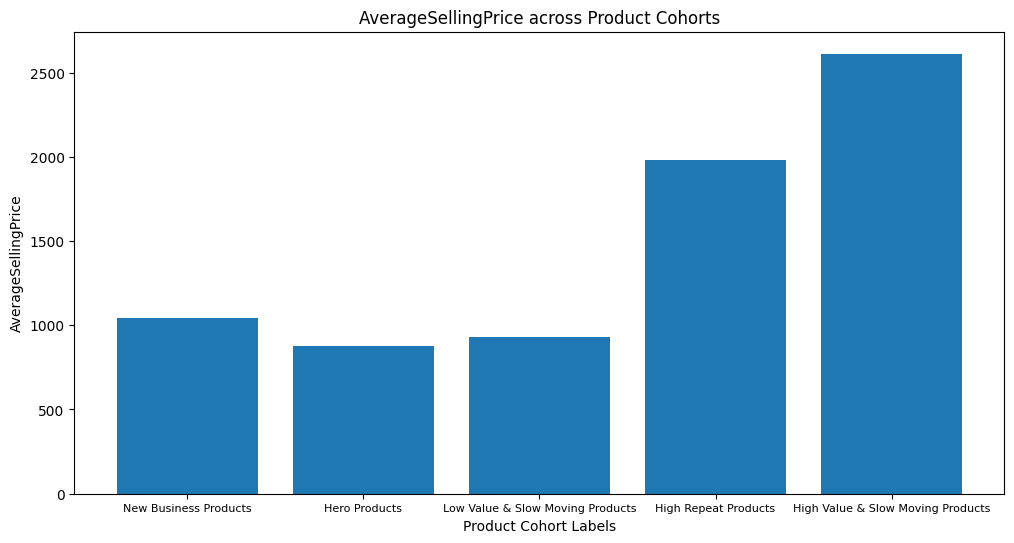

In [316]:
column_to_plot = 'AverageSellingPrice'
x_labels = p1['Product Cohort Lables']
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.bar(x_labels, p1[column_to_plot])
plt.xlabel('Product Cohort Labels')
plt.ylabel(column_to_plot)
plt.title(f'{column_to_plot} across Product Cohorts')
plt.xticks(fontsize=8)
plt.show()

In [ ]:
# #Visualization of cohorts with key parameters as axises
# fig = plt.figure(figsize = (15, 15))
# ax = plt.axes(projection ="3d")
# size=segstats['Users']*.05
# # Creating plot
# ax.scatter3D(segstats['CartPenetration'], segstats['NewUserRatio'],segstats['AverageSellingPrice'], s=size)
# plt.title("Product Cohort Distribution")
# ax.set_xlabel('CartPenetration', fontweight ='bold')
# ax.set_ylabel('NewUserRatio', fontweight ='bold')
# ax.set_zlabel('AverageSellingPrice', fontweight ='bold')
# for i in range(len(segstats)):
#      ax.text(segstats['CartPenetration'][i],
#                segstats['NewUserRatio'][i],
#              segstats['AverageSellingPrice'][i],
#                segstats['Product Cohort Lables'][i],
#                horizontalalignment='left',
#                rotation=25, wrap=True,
#                verticalalignment='center',
#                size='medium', color='black')
